# Transfer Learning with TensorFlow, Fine-Tuning

In [1]:
# Check for GPU 
!nvidia-smi

Tue Aug 23 21:27:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrithe them all. This is tedious though.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2022-08-23 21:27:18--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2022-08-23 21:27:18 (84.3 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import helper functions we are going to use in this notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

Using the pretrained models within `tf.keras.applications`

[link here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [4]:
# Get 10% of trainig data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-08-23 21:43:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  96.7MB/s    in 1.7s    

2022-08-23 21:43:30 (96.7 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [7]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

# Using image data from directory, all in one hit, no need for image_datagen instance
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # Means that the labels are encoded as a categorical vector (for `categorical_crossentropy` loss), for multiclass data 
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# tf have turned the data into batches(BatchDataset)
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

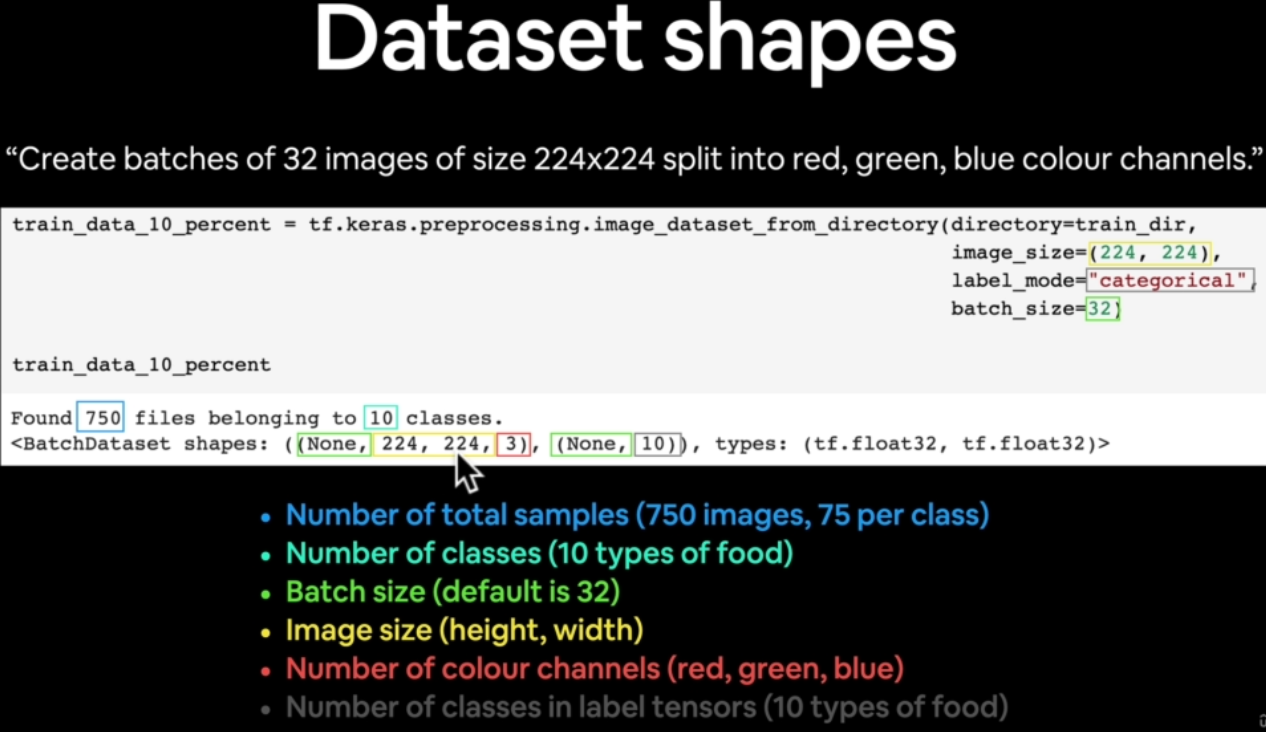

In [10]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.35000000e+02 1.44357147e+02 1.58285721e+02]
   [1.35954086e+02 1.45311234e+02 1.59239792e+02]
   [1.37494888e+02 1.46852036e+02 1.60780609e+02]
   ...
   [1.74785736e+02 1.73000000e+02 1.87428528e+02]
   [1.75000000e+02 1.73000000e+02 1.86000000e+02]
   [1.75642853e+02 1.73000000e+02 1.84714279e+02]]

  [[1.36071426e+02 1.46071426e+02 1.58071426e+02]
   [1.37066330e+02 1.47066330e+02 1.59066330e+02]
   [1.38285706e+02 1.48285706e+02 1.60285706e+02]
   ...
   [1.74969391e+02 1.74015305e+02 1.90000000e+02]
   [1.74000000e+02 1.73000000e+02 1.87000000e+02]
   [1.74857147e+02 1.73000000e+02 1.85928574e+02]]

  [[1.37000000e+02 1.47000000e+02 1.57428574e+02]
   [1.37984695e+02 1.47984695e+02 1.58413269e+02]
   [1.39214279e+02 1.49214279e+02 1.59642853e+02]
   ...
   [1.73336746e+02 1.74831635e+02 1.90000000e+02]
   [1.72428574e+02 1.73785721e+02 1.87000000e+02]
   [1.71428574e+02 1.73000000e+02 1.85785721e+02]]

  ...

  [[1.28923462e+02 1.33923462e+02 1.37923462e+02]
   [1